# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [161]:
!pip install --upgrade seaborn==0.9.0

In [162]:
import csv
import urllib.request
import pandas as pd
import tweepy
import os
import os.path
import requests
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
%matplotlib inline
from matplotlib import rcParams

In [163]:
cwd = os.getcwd() #working directory
base_path = os.getcwd()

In [164]:
def file_exists(base_p, file_name):
    return(os.path.exists(os.path.join(base_p, file_name)))

In [165]:
#if the file does not exist, download it to the working directory.
if (not(file_exists(base_path,"twitter-archive-enhanced.csv"))):
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'
    file_to_read = urllib.request.urlopen(url)
    df_ta = pd.read_csv(file_to_read)
    df_ta.to_csv(os.path.join(base_path, "twitter-archive-enhanced.csv"))
else:
    file_to_read = os.path.join(base_path, "twitter-archive-enhanced.csv")
    df_ta = pd.read_csv(file_to_read)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [166]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = urllib.request.urlopen(url)
df_ipr = pd.read_csv(response, sep = '\t')
df_ipr.to_csv('image-predictions.tsv')
df_ipr.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


Getting all tweet_ids for querying Twitter API later:

In [167]:
tweet_ids = df_ta['tweet_id'].astype(str)
df_ipr.shape[0]

2075

3. Use the Requests library to query additional data via the Twitter API (tweet_json.txt)

In [168]:
#authorization: read the file with bearer token. It's one string with tocken
path_to_bearer_token = os.path.join(base_path, "bearer_token.txt")
with open(path_to_bearer_token, 'r') as f:    
    bearer_token = f.read()

In [169]:
# Big Thanks to https://www.kaggle.com/andrewedward37/data-collection-with-twitter-api-v2 for 
# the excellent guide about Twitter API 2.0

#get one tweet url for using it in request (IT WAS USED FOR TESTING AND DEBUGGING ONLY)
def get_tweat_url(tw_id):
    '''the function takes an int tweet ID and returns a tuple with strings with URL and query parameters for requesting later'''
    twitter_url = "https://api.twitter.com/2/tweets/" + str(tw_id)
    query_params = {'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source,text',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (twitter_url, query_params)

def get_ids_string(start, quantity, tw_ids_series):
    '''start : int, quantity: int, tw_ids_series : pandas.series of integeres. It takes a series of id's, start position/
    within series and the batch length. It returns the formatted string with id's for requesting Twitter API 2.0'''
    result = ''
    for i in range(start, start + quantity):
        if i in tw_ids_series.index:
            if len(result) > 0:
                result = result +','+ tw_ids_series[i]
            else:
                result = tw_ids_series[i]
        else:
            i-=1
            break
    return (result, i-start+1)

def get_tweats_url(tw_ids):
    '''the function takes the tweets ids string (get_ids_string output) and returns a tuple with strings with URL and query \
    parameters for requesting later'''
    twitter_url = "https://api.twitter.com/2/tweets"
    query_params = {'ids': tw_ids,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source,text',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (twitter_url, query_params)

def connect_to_twitter(url, headers, params, next_token = None):
    '''the function takes the url, headers, and query parameters (get_tweats_url output) and returns a tuple with strings \
    with URL, and returns a response in JSON format'''
    params['next_token'] = next_token
    resp = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(resp.status_code))
    if resp.status_code != 200:
        raise Exception(resp.status_code, resp.text)
    return (resp.json())
  
def make_request(tweets_ids, time_window = 1700, requests_limit = 50):
    '''The function takes the tweet id's string (get_ids_string output), the time window in seconds (Twitter's time window) \
    and the request limit within the time window. It returns a tuple with response in JSON format and False if the limit of \
    requests exceeded. For tracking requests, it creates or reads file rqsts.csv. Old records within rqsts.csv are \
    deleting automatically '''
    if (file_exists(base_path, 'rqsts.csv')):
        rqsts = pd.read_csv(os.path.join(base_path, 'rqsts.csv'), names = ['timestamp'])
        rqsts_s = rqsts['timestamp']
    else:
        rqsts_s = pd.Series([])
    current_time = time.time()
    rqsts_f = rqsts_s[rqsts_s > (current_time - time_window)]
    if (rqsts_f.shape[0] < requests_limit):
        #do request
        url = get_tweats_url(tweets_ids)
        headers = {"Authorization": "Bearer " + bearer_token}
        rqsts_f = rqsts_f.values.tolist()
        rqsts_f.append(current_time)
        rqsts_f = pd.Series(rqsts_f)
        rqsts_f.to_csv(os.path.join(base_path, 'rqsts.csv'))
        json_resp = connect_to_twitter(url[0], headers, url[1])
        print("request completed")
        return(json_resp, True)
    else:
        print('limit of request exceeded: requests= ', rqsts_f.shape[0], 'limit=', requests_limit)
        return(0, False)
    
def pull_all_data(ids_series, batch_size = 5, time_window = 950, req_limit = 50, sleep_time = 10):
    '''The function takes the series of ids of integer type, batch_size, time_window in seconds, request limit \
    and the sleep time in seconds. It saves all pulled data in the file tweet_json.txt one tweet per line in JSON format.'''
    if (file_exists(base_path, 'tweet_json.txt')):
        #workaround the insidious bug in read_json method of pandas: "https://github.com/pandas-dev/pandas/issues/20608#"
        #some random id's in my dataframe became  a little bit different tnan they should be...
        #I spend one hour to understand that my code is fine, it's pandas bug :-)
        try: 
            tweet_json_df = pd.read_json(os.path.join(base_path, 'tweet_json.txt'), lines=True, orient='index' \
                                          , convert_axes=False, dtype={}).transpose()
        except:
            tweet_json_df = pd.read_json(os.path.join(base_path, 'tweet_json.txt'), lines=True, convert_axes=False, dtype={})
       
        last_id = tweet_json_df.iloc[-1:]['id'].values[0] # the id of the last tweet in the output file (single value)
        idx = (df_ta.index[df_ta['tweet_id'].astype(str) == last_id])
        start_line = (idx[0].item()) + 1 #number of string to start, converted to basic python type
    else:
        start_line = 0
    count = 0
    for current_line in range(start_line, ids_series.shape[0], batch_size):
        ids = get_ids_string(current_line, batch_size, ids_series)
        rsp = ('', False)
        while (rsp[1]!= True):
            time.sleep(1)
            rsp = make_request(ids[0],time_window, req_limit)
            if (rsp[1]!= True): #we exceed the limit
                print('waiting ', sleep_time, ' seconds' )
                time.sleep(sleep_time)
        if (not((rsp[0].get('data')) is None)):
            missed_id_flag = False
            for object_number in range(0,len(rsp[0].get('data'))): #check, maybe ids[1] +1
                if (len(rsp[0].get('data')) < batch_size):
                    missed_id_flag = True
                with open('tweet_json.txt', 'a') as out_f:
                    json.dump(rsp[0].get('data')[object_number],out_f)
                    out_f.write('\n')
                    count +=1
            if (missed_id_flag):
                print('Missed id is here ------------>') #monitoring cases where response has less than batch_size data
    print('records completed =', count)

In [170]:
pull_all_data(df_ta['tweet_id'].astype(str), batch_size = 50, time_window = 905, req_limit = 50, sleep_time = 10)

limit of request exceeded: requests=  50 limit= 50
waiting  10  seconds
limit of request exceeded: requests=  50 limit= 50
waiting  10  seconds
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Response Code: 200
request completed
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Response Code: 200
request completed
Endpoint Response Code: 200
request completed
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Response Code: 200
request completed
Missed id is here ------------>
Endpoint Respons

We got only 2328 records instead of 2358 expected (the length of df_ta data frame). Let try to find the destiny of all missed tweets:

In [171]:
# find all missed id's in the first 200 rows:

try:
    tweet_json_df = pd.read_json(os.path.join(base_path, 'tweet_json.txt'), lines=True, orient='index' \
                                 , convert_axes=False, dtype={}).transpose()
except:
    tweet_json_df = pd.read_json(os.path.join(base_path, 'tweet_json.txt'), lines=True, convert_axes=False, dtype={})

df2 = tweet_json_df[['id','conversation_id']]
df1 = df_ta[['tweet_id','timestamp']].head(200)
df1['id'] = df_ta['tweet_id'].astype(str)
df = pd.merge(df1, df2, on ='id', how ="left")[pd.merge(df1, df2, on ='id', how ="left")['conversation_id'].isna()]
missed_ids = df['tweet_id'].astype(str).str.cat(sep=',')
print(missed_ids)
rsp = make_request(missed_ids,905, 50)
if rsp is not None:
    if (not((rsp[0].get('data')) is None)):
        for object_number in range(0,len(rsp[0].get('data'))): 
            if (len(rsp[0].get('data')) < 9):
                print('HERE------------>')
            with open('bbb.txt', 'a') as out_f:
                json.dump(rsp[0].get('data')[object_number],out_f)
                out_f.write('\n')
    else:
        print('data = null, so the tweets do not exist now')


888202515573088257,873697596434513921,872668790621863937,872261713294495745,869988702071779329,866816280283807744,861769973181624320,856602993587888130,856330835276025856
Endpoint Response Code: 200
request completed
data = null, so the tweets do not exist now


It means that all results are correct, and all missed ids reference non-existing now tweets (deleted).

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

First, let merge all 3 dataframes to one:

In [172]:
df2 = tweet_json_df
df1 = df_ta
df1['id'] = df_ta['tweet_id'].astype(str)
df_mergd1 = pd.merge(df1, df2, on ='id', how ="left") # The left join was choosen for easy indetification of
#missing records after joining dataframes with fewer records
df_ipr['id'] = df_ipr['tweet_id'].astype(str)
master_df = pd.merge(df_mergd1, df_ipr, on ='id', how ="left")

In [173]:
master_df.head(3)

,Unnamed: 0,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id_x,timestamp,source_x,text_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [174]:
master_df.describe()

,Unnamed: 0,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id_x,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,tweet_id_y,img_num,p1_conf,p2_conf,p3_conf
count,2356.000000,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,1177.500000,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,680.262939,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,0.000000,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,588.750000,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,1177.500000,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,1766.250000,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,2355.000000,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [175]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   Unnamed: 0                  2356 non-null   int64              
 1   tweet_id_x                  2356 non-null   int64              
 2   in_reply_to_status_id       78 non-null     float64            
 3   in_reply_to_user_id_x       78 non-null     float64            
 4   timestamp                   2356 non-null   object             
 5   source_x                    2356 non-null   object             
 6   text_x                      2356 non-null   object             
 7   retweeted_status_id         181 non-null    float64            
 8   retweeted_status_user_id    181 non-null    float64            
 9   retweeted_status_timestamp  181 non-null    object             
 10  expanded_urls               2297 non-null   object          

Quantity of records with not valid numerators:

In [176]:
master_df[(master_df['rating_numerator'] >20)].count()[0]

24

Quantity of records with not valid denominators:

In [177]:
master_df[(master_df['rating_denominator'] != 10)].count()[0]

23

Quantity of records with not original tweets:

In [178]:
master_df[(master_df['retweeted_status_id'].isna() == False) | (master_df['in_reply_to_status_id'].isna() == False)].count()[0]

259

Quantity of records with non existing now tweets

In [179]:
master_df['text_y'].isna().sum() #5

28

Quantity of records with non existing expanded_urls:

In [180]:
master_df[master_df['expanded_urls'].isna()][['expanded_urls', 'tweet_id_x']].count() 

expanded_urls     0
tweet_id_x       59
dtype: int64

### Quality issues
1. All columns related to the df_ipr data frame have fewer non-null values than others. It is caused by less quantity of rows. (2075 compared to 2356)

2. The expanded_urls column has fewer non-null values than it should be (2297 instead of 2356)

3. Some tweets IDs in df_ta were wrong or deleted in Twitter. (see "#find all missed id's"). It caused null values in all columns related to tweet_json_df data frame (text_y, lang, etc.) 

4. Some records (with non-null values in columns like 'in_reply_to_status_id' ) are not original tweets as required

5. Some of the columns have only a few non-null rows. (geo)

6. Some of the rows have all three non-dog values in p1, p2, p3 dog columns

7. The timestamp column has string type.

8. The column rating_numerator has a minimum of 0, whereas the valid minimum is 10 (" Almost always greater than 10"). And maximum is over 1700 that is not good too. 

9. The column rating_denominator: it should be 10, but the min is 0, max is 170.

10. Columns  doggo, floofer, pupper, puppo have string None values. They sould be reolaced on NaN.



### Tidiness issues
1. Dataset has a lot of redundant columns such as in_reply_to_status_id and in_reply_to_user_id_x, id and tweet_id, and conversation_id, etc. 
2. doggo, floofer, upper, and puppo it's one categorical variable. It should be one column instead of 4.
3. values in public_metrics are dictionaries. It should be converted to several columns like reply_count, like_count, etc
4. Columns rating_denominator and rating_numerator should be combined into one variable


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [181]:
# Make copies of original pieces of data
tweet_json_copy_df = tweet_json_df.copy()
df_ta_copy =  df_ta.copy()
df_ipr_copy = df_ipr.copy()

### Issue #1:

#### Define: Drop all rows with null values in column jpg_url. (all rows without images)

#### Code

In [182]:
master_df.dropna(subset = ['jpg_url'], inplace=True) 

#### Test

In [183]:
master_df['jpg_url'].isna().sum()

0

### Issue #2:

####  Delete all rows with null values in the column expanded_urls

#### Code

In [184]:
master_df.dropna(subset = ['expanded_urls'], inplace=True) 

#### Test

In [185]:
master_df['expanded_urls'].isna().sum()

0

### Issue #3:

####  Drop all rows with null values in column lang. (we are deleting all rows with id's where Twitter responded null in data (see #find all missed id's")

#### Code

In [186]:
master_df.dropna(subset = ['lang'], inplace=True) 

#### Test

In [187]:
master_df['lang'].isna().sum()

0

### Issue #4:

####  Dropped all rows with non-null values in columns in_reply_to_status_id and retweeted_status_id (we need only original tweets):

#### Code

In [188]:
master_df = master_df[(master_df['in_reply_to_status_id'].isna()) & (master_df['retweeted_status_id'].isna())]

#### Test

In [189]:
master_df[(master_df['in_reply_to_status_id'].notna()) | (master_df['retweeted_status_id'].notna())].count()[0]

0

### Quality Issues #5 and #7 , tidiness issue #1 :

#### Drop redundant and unuseful columns (including timestamp because we have the same data in the column createad_at in the right format)

#### Code

In [190]:
master_df.columns

Index(['Unnamed: 0', 'tweet_id_x', 'in_reply_to_status_id',
       'in_reply_to_user_id_x', 'timestamp', 'source_x', 'text_x',
       'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'id', 'reply_settings', 'author_id', 'source_y', 'conversation_id',
       'created_at', 'text_y', 'public_metrics', 'lang', 'referenced_tweets',
       'in_reply_to_user_id_y', 'geo', 'tweet_id_y', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

In [191]:
columns_to_delete = ['tweet_id_x', 'in_reply_to_status_id', 'in_reply_to_user_id_x'
                     , 'timestamp', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'
                     , 'text_y', 'lang', 'source_y', 'in_reply_to_user_id_y', 'geo', 'tweet_id_y'
                     , 'conversation_id', 'referenced_tweets']
if 'Unnamed: 0' in master_df.columns:
    columns_to_delete.append('Unnamed: 0')

In [192]:
master_df = master_df.drop(columns=columns_to_delete)


#### Test

In [193]:
master_df.columns

Index(['source_x', 'text_x', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'id', 'reply_settings', 'author_id', 'created_at', 'public_metrics',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

### Quality Issue #6:

####  Drop all rows with three False values  in one row in columns p1_dog, p2_dog, p3_dog. (records where prediction is not a dog)

####  Code.

In [194]:
master_df = master_df[(master_df['p1_dog'] == True) | (master_df['p2_dog'] == True) | (master_df['p3_dog'] == True)]

#### Test

In [195]:
master_df[(master_df['p1_dog'] == False) & (master_df['p2_dog'] == False) & (master_df['p3_dog'] == False)][['p1_dog', 'p2_dog', 'p3_dog']]

,p1_dog,p2_dog,p3_dog


### Quality Issue #8 and #9, tidiness issue 4:

####  Replace not valid values. Combine into one variable

####  Code.

First we should add 10 to all numerator values where denominator is less then 10.
Quantity of rows with wrong rating_denominator: 

In [196]:
master_df[((master_df['rating_numerator'] <= 10) & (master_df['rating_denominator'] < 10))].shape[0]

1

In [197]:
def add_10(nom, denom):
    if ((denom < 10) & (nom <= 10)):
        nom += 10
    return(nom)
master_df['rating_numerator'] = master_df.apply(lambda row: add_10(row['rating_numerator'], row['rating_denominator']), axis = 1)

### Test:
List of rows with wrong rating_denominator: 

In [198]:
master_df[((master_df['rating_numerator'] <= 10) & (master_df['rating_denominator'] < 10))].shape[0]

0

List of rows with wrong rating_numerator > 20:

In [199]:
master_df[(master_df['rating_numerator'] > 20)].head(3)

,source_x,text_x,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
433,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None,...,2.0,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True
516,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None,...,1.0,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True
695,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None,...,1.0,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True


I don't see the correct way to convert these values to a valid range. So they are outliers. They should be deleted.

In [200]:
master_df = master_df[master_df['rating_numerator'] <= 20]

### Test:
List of rows with wrong rating_numerator > 20:

In [201]:
master_df[(master_df['rating_numerator'] > 20)]

,source_x,text_x,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


Finally, we should decide how to cast the above 2 columns into one variable. Taking into account the principle "Almost always greater than 10", we simply delete the denominator column:

In [202]:
master_df = master_df.drop(columns=['rating_denominator'])

### Test:
List of columns:

In [203]:
master_df.columns

Index(['source_x', 'text_x', 'expanded_urls', 'rating_numerator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'id', 'reply_settings',
       'author_id', 'created_at', 'public_metrics', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

### Quality Issue #10 and tidiness issue 2:

####    Combine columns doggo, floofer, pupper, puppo columns into one variable. Replace None with nan.

####  Code.

In [204]:
master_df[['doggo', 'floofer', 'pupper', 'puppo']] = master_df[['doggo', 'floofer', 'pupper', 'puppo']].replace(to_replace='None', value ='')
master_df[['doggo', 'floofer', 'pupper', 'puppo']].iloc[0]

doggo      
floofer    
pupper     
puppo      
Name: 1, dtype: object

In [205]:
def concat(s1, s2):
    if (len(s1) == 0):
        return (s2)
    elif(len (s2) > 0):
        return (s1 + ', ' + s2)
    else:
        return (s1)
    



def dog_stage_cast(c1, c2 ,c3, c4):
    res = concat(c1, c2)
    res = concat (res, c3)
    res = concat (res, c4)
    return (res)
    
master_df['dog_stage']  = master_df.apply(lambda row: dog_stage_cast(row['doggo'], row['floofer'], row['pupper'], row['puppo']), axis = 1)        
    
        
#master_df['dog_stage'] = master_df['doggo'] + master_df['floofer'] + master_df['pupper'] + master_df['puppo']

#master_df.apply(lambda row: breed(row['p1'], row['p1_dog'], row['p2'], row['p2_dog'], row['p3'], row['p3_dog']), axis = 1)

In [206]:
master_df = master_df.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'])

In [207]:
master_df['dog_stage'] = master_df['dog_stage'].replace('',np.nan)

### Test:

In [208]:
master_df['dog_stage'].unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

### Tidiness issue #3:

####  Convert 'public_metrics into 4 variables:

####  Code.

In [209]:
master_df = master_df.drop('public_metrics', axis=1).join(pd.DataFrame(master_df.public_metrics.values.tolist()))

#### Test

In [210]:
print(master_df.columns)
print (master_df[['retweet_count',
       'reply_count', 'like_count', 'quote_count']].head(3))

Index(['source_x', 'text_x', 'expanded_urls', 'rating_numerator', 'name', 'id',
       'reply_settings', 'author_id', 'created_at', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'dog_stage', 'retweet_count', 'reply_count', 'like_count',
       'quote_count'],
      dtype='object')
   retweet_count  reply_count  like_count  quote_count
1         3525.0        110.0     22351.0        145.0
2         7306.0        143.0     37386.0        286.0
3         7860.0        196.0     35725.0        296.0


Check the dataset:

In [211]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643 entries, 1 to 2355
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   source_x          1643 non-null   object             
 1   text_x            1643 non-null   object             
 2   expanded_urls     1643 non-null   object             
 3   rating_numerator  1643 non-null   int64              
 4   name              1643 non-null   object             
 5   id                1643 non-null   object             
 6   reply_settings    1643 non-null   object             
 7   author_id         1643 non-null   object             
 8   created_at        1643 non-null   datetime64[ns, UTC]
 9   jpg_url           1643 non-null   object             
 10  img_num           1643 non-null   float64            
 11  p1                1643 non-null   object             
 12  p1_conf           1643 non-null   float64            
 13  p1_

As we can see, after converting public_metrics they have some null values, which is not right. Let to replace them on zero:

In [212]:
 master_df[['retweet_count', 'reply_count', 'like_count'
            , 'quote_count']] = master_df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].fillna(0)

### Test:

In [213]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643 entries, 1 to 2355
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   source_x          1643 non-null   object             
 1   text_x            1643 non-null   object             
 2   expanded_urls     1643 non-null   object             
 3   rating_numerator  1643 non-null   int64              
 4   name              1643 non-null   object             
 5   id                1643 non-null   object             
 6   reply_settings    1643 non-null   object             
 7   author_id         1643 non-null   object             
 8   created_at        1643 non-null   datetime64[ns, UTC]
 9   jpg_url           1643 non-null   object             
 10  img_num           1643 non-null   float64            
 11  p1                1643 non-null   object             
 12  p1_conf           1643 non-null   float64            
 13  p1_

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [214]:
master_df.to_csv(os.path.join(base_path, 'twitter_archive_master.csv'), index = False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [215]:
#public metrics and rating statistic info:
master_df[['retweet_count', 'reply_count', 'like_count', 'quote_count', 'rating_numerator']].describe()

,retweet_count,reply_count,like_count,quote_count,rating_numerator
count,1643.000000,1643.000000,1643.000000,1643.000000,1643.000000
mean,1597.749239,32.162508,5540.356665,55.245283,10.806452
std,3878.578685,72.869277,11082.040050,216.382348,1.791925
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,10.000000
50%,530.000000,14.000000,1877.000000,0.000000,11.000000
75%,1694.000000,35.000000,6243.000000,43.500000,12.000000
max,71832.000000,1143.000000,146568.000000,4347.000000,14.000000


Most frequent rating_numerator (rating):

In [216]:
most_fr_r = master_df['rating_numerator'].value_counts()[:3].index.tolist()
most_fr_r

[12, 10, 11]

Text(0, 0.5, 'frequency')

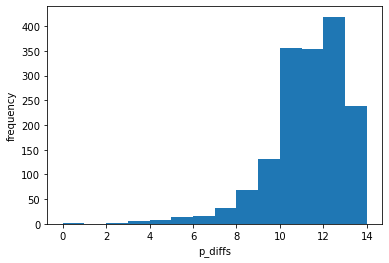

In [217]:
plt.hist(master_df['rating_numerator'], bins= 14);
plt.xlabel('p_diffs')
plt.ylabel('frequency')

Three the most common names:

In [218]:
most_fr_n = master_df['name'].value_counts()[:5].index.tolist()
most_fr_n[2:] # to avoid None and a

['Cooper', 'Oliver', 'Charlie']

The most common dog breed. Top ten breeds
casting 3 columns with breed to one:

In [219]:
def breed(p1 , p1_dog, p2 , p2_dog, p3, p3_dog):
    rez =''
    if (p1_dog):
        rez = p1
    elif (p2_dog):
        rez = p2
    elif (p3_dog):
        rez = p3
    else:
        rez = 'error'
    return(rez)

In [220]:
master_df['breed'] = master_df.apply(lambda row: breed(row['p1'], row['p1_dog'], row['p2'], row['p2_dog'], row['p3'], row['p3_dog']), axis = 1)

top ten breeds:

In [221]:
top_10_breeds = (master_df['breed'].value_counts()).head(10).index
all_breeds = (master_df['breed'].value_counts()).index


In [222]:
def top_breeds(p1 , top_b):
    if p1 not in top_b:
        rez = 'other'
    else:
        rez = p1
    return(rez)
    

In [223]:
master_df['top_breeds'] = master_df.apply(lambda row: top_breeds(row['breed'], top_10_breeds), axis = 1)
master_df['top_breeds'].value_counts()

other                 933
golden_retriever      154
Labrador_retriever    100
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             49
chow                   47
Samoyed                41
Pomeranian             40
malamute               33
Name: top_breeds, dtype: int64

In [224]:
breeds_df = master_df['breed'].value_counts()

In [225]:
breeds_df = breeds_df.to_frame()

In [226]:
breeds_df['percent'] = breeds_df['breed'] / breeds_df['breed'].sum()*100
breeds_df['percent'].head(5)

golden_retriever      9.373098
Labrador_retriever    6.086427
Pembroke              5.721242
Chihuahua             5.477785
pug                   3.773585
Name: percent, dtype: float64

In [227]:
breeds_df_wo_other = breeds_df[(breeds_df.index != 'other') & (breeds_df['percent'] >= 1)] 

Rating vs all social metrics:

creating a dataframe with social merics above 0:

In [228]:
soc_metrics_above_0_df = master_df[(master_df['retweet_count'] > 0) | (master_df['reply_count'] > 0) 
                                   | (master_df['like_count'] > 0) | (master_df['quote_count'] > 0)]

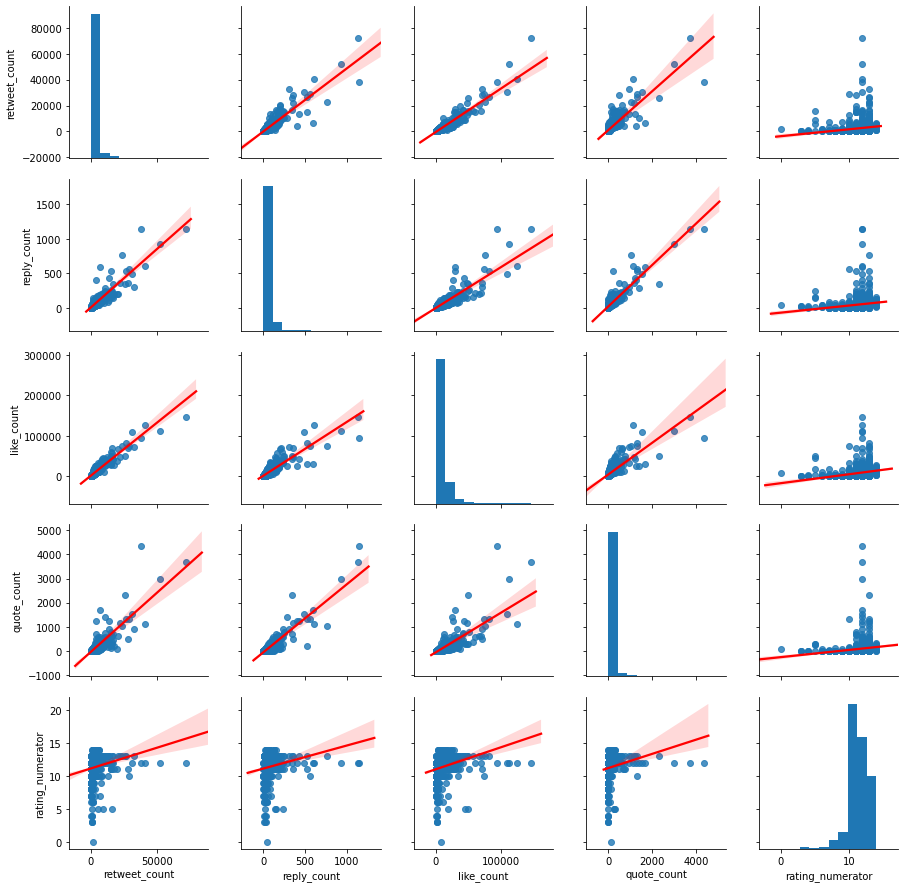

In [229]:
sns.pairplot(soc_metrics_above_0_df[['retweet_count', 'reply_count', 'like_count' , 'quote_count'
                                     , 'rating_numerator']], kind="reg", plot_kws={'line_kws':{'color':'red'}});

The most popular tweet:

In [230]:
id_max_l = soc_metrics_above_0_df[soc_metrics_above_0_df['like_count'] == soc_metrics_above_0_df['like_count'].max()]['id'].iloc[0]
soc_metrics_above_0_df[soc_metrics_above_0_df['id'] == id_max_l]

,source_x,text_x,expanded_urls,rating_numerator,name,id,reply_settings,author_id,created_at,jpg_url,...,p3,p3_conf,p3_dog,dog_stage,retweet_count,reply_count,like_count,quote_count,breed,top_breeds
674,"<a href=""http://twitter.com/download/iphone"" r...",This is Brownie. She's wearing a Halloween the...,https://twitter.com/dog_rates/status/789599242...,12,Brownie,789599242079838210,everyone,4196983835,2016-10-21 22:48:24+00:00,https://pbs.twimg.com/media/CvU4UZpXgAE1pAV.jpg,...,Labrador_retriever,0.017499,True,NaN,71832.0,1136.0,146568.0,3705.0,Chesapeake_Bay_retriever,other


### Insights:
1. The mean of rating_numerator is 10.8 whereas the three most frequent values are 12,10 and 11. The distribution is skewed left.
2. Tweets with ratings around 5 and 13 have a higher average likes count and retweet count.
3. Looking at the dog stages, pupper is the most frequent stage, whereas doggo, puppo combined category or doggo single category have maximum likes.
4. The golden retriever is the most common breed, whereas labrador retriever has the maximum of likes
5. If the tweet has a higher likes quantity, it has more retweets.
6. The most frequent names are Cooper, Oliver, and Lucy.


### Visualization

The most popular tweet image

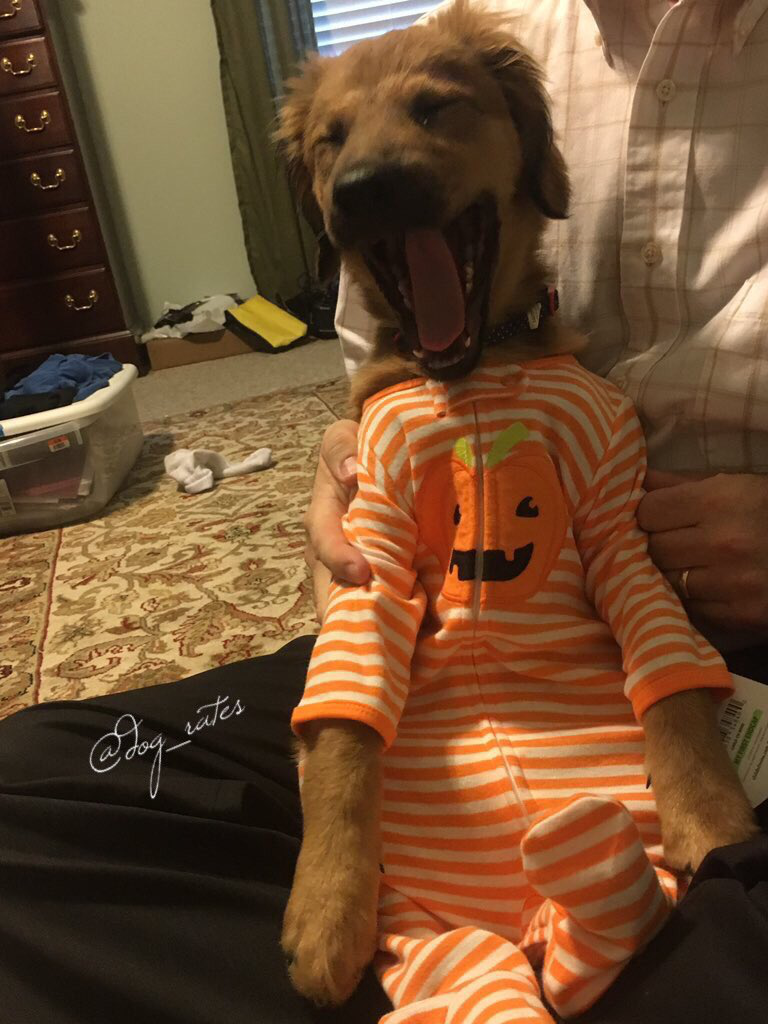

In [231]:
url = soc_metrics_above_0_df[soc_metrics_above_0_df['id'] == id_max_l]['jpg_url'].iloc[0]
im_r= requests.get(url)
im = Image.open(BytesIO(im_r.content))
im

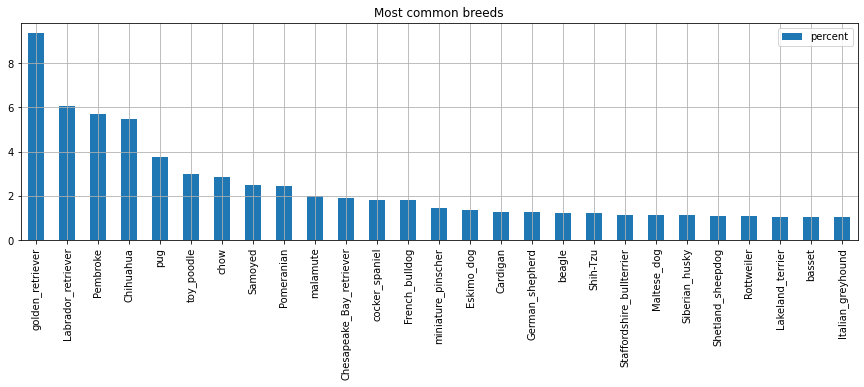

In [232]:
plot = breeds_df_wo_other['percent'].plot.bar(y='Percent', title="Most common breeds"
                                              , legend=True, figsize = (15,4), grid = True)

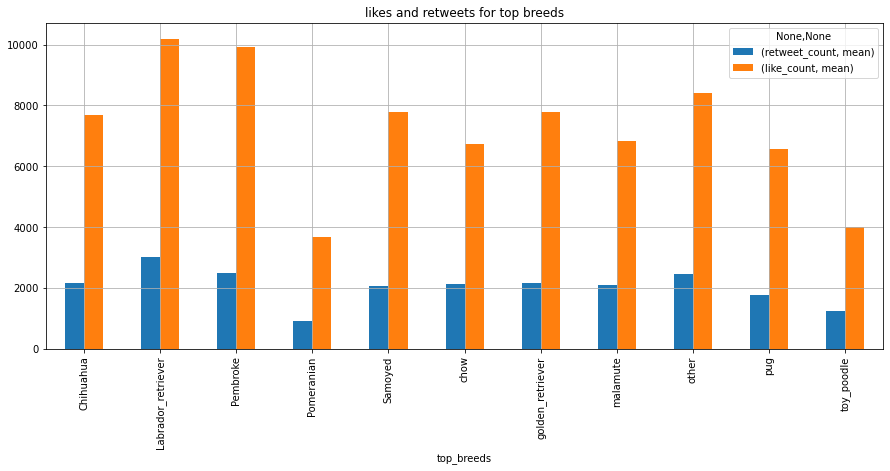

In [233]:
col = ['retweet_count', 'reply_count', 'like_count', 'quote_count', 'top_breeds']
df = soc_metrics_above_0_df[col]
grf = df.groupby('top_breeds').agg({np.mean}).plot(y=['retweet_count', 'like_count'], kind='bar'
                                                   , figsize = (15,6), grid = True, title = 'likes and retweets for top breeds')

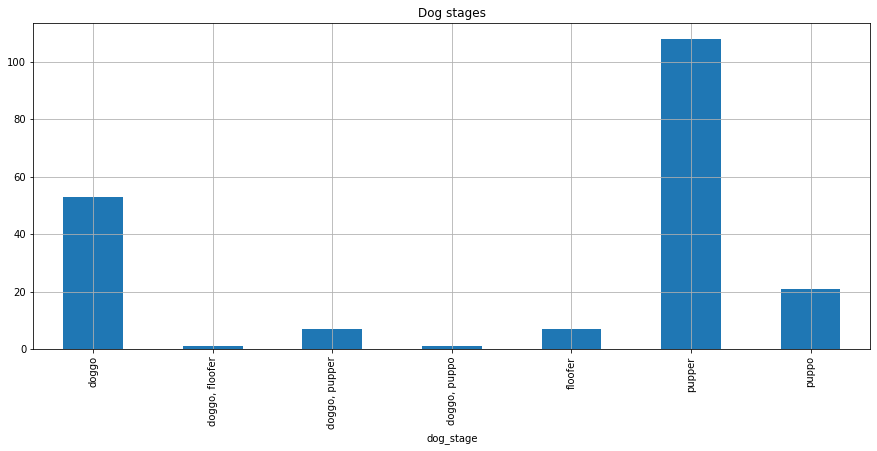

In [234]:
grf = soc_metrics_above_0_df.groupby('dog_stage').count() \
['author_id'].plot(kind='bar' , figsize = (15,6), grid = True, title = 'Dog stages')

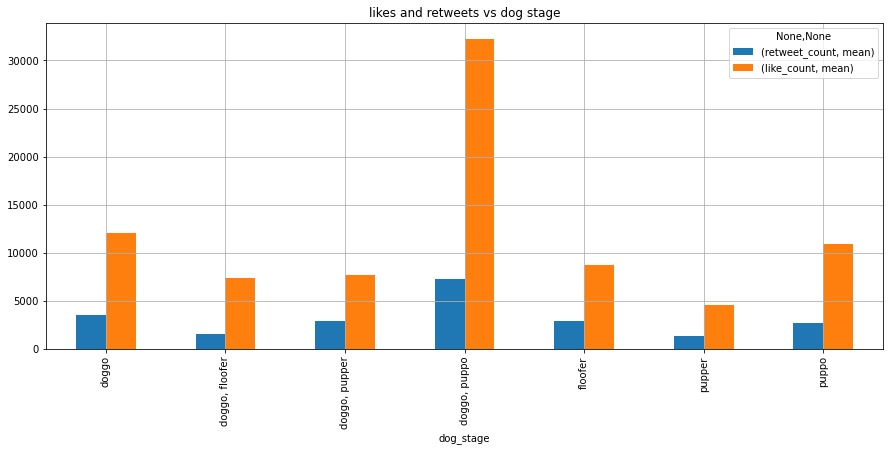

In [235]:
col = ['retweet_count', 'reply_count', 'like_count', 'quote_count', 'dog_stage']
grf = soc_metrics_above_0_df[col].groupby('dog_stage').agg({np.mean}).plot(y=['retweet_count', 'like_count'] \
, kind='bar', figsize = (15,6), grid = True, title = 'likes and retweets vs dog stage')

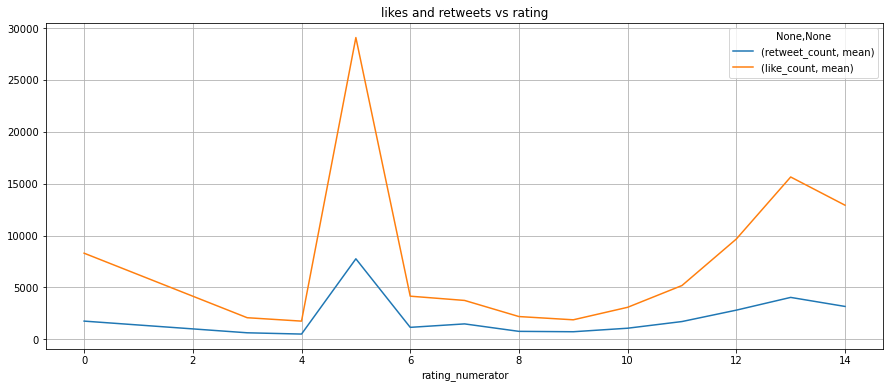

In [236]:
col = ['retweet_count', 'reply_count', 'like_count', 'quote_count', 'rating_numerator']
df = soc_metrics_above_0_df[col]
grf = df.groupby('rating_numerator').agg({np.mean}).plot(y=['retweet_count', 'like_count'] \
                                        ,kind='line', figsize = (15,6), grid = True, title = 'likes and retweets vs rating')

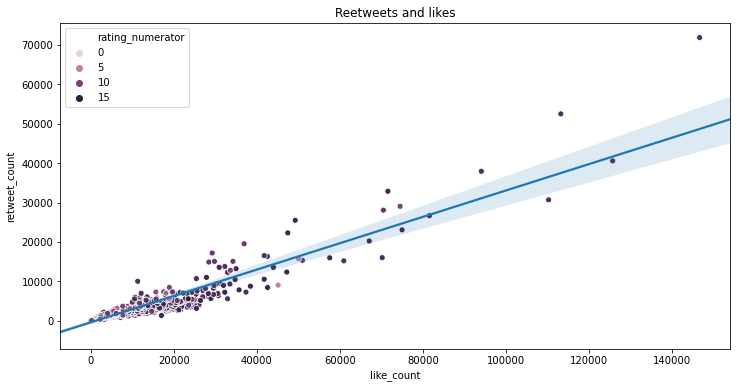

In [237]:
data1 = soc_metrics_above_0_df[['retweet_count', 'like_count', 'rating_numerator']]
rcParams['figure.figsize'] = 12,6 # figure size in inches
grf = sns.scatterplot(data=data1, x='like_count', y='retweet_count', hue='rating_numerator').set(title='Reetweets and likes')
sns.regplot(data=data1, x='like_count', y='retweet_count', scatter=False);